In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
import os
%matplotlib inline

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In order to increase the size of the training data each ROI was cut possibly used multiple times, at different zooms and possibly cut into multiple tiles, depending on the size of the ROI. Because of this, combining and shuffling all the data will result in different versions of the same images being included in both the training and test data sets. 

To prevent this I keep the CBIS images separated into training and test sets, then split the normal images (which should have no overlap) up into training and test data. The MIAS images are added to the training data, while the test data is kept completely separate. This ensures that the training and test data come from the same distribution while preventing different versions of the same images from being included in both.

Ideally I would have liked to have the test and validation datasets bigger than they are, but the size of the datasets were limited by the number of test scans in the CBIS-DDSM data.

The data has been split up such as to keep the distribution of all data sets at about 85% normal.

In [2]:
# load the data
train_cbis_slices = np.load(os.path.join("data", "cbis_train_slices.npy"))
train_cbis_labels = np.load(os.path.join("data", "cbis_train_labels.npy"))
train_cbis_filenames = np.load(os.path.join("data", "cbis_train_names.npy"))

test_cbis_slices = np.load(os.path.join("data", "cbis_test_slices.npy"))
test_cbis_labels = np.load(os.path.join("data", "cbis_test_labels.npy"))
test_cbis_filenames = np.load(os.path.join("data", "cbis_test_names.npy"))

normal_slices_0 = np.load(os.path.join("data", "image_batch_0.npy"))
normal_labels_0 = np.load(os.path.join("data", "label_batch_0.npy"))

normal_slices_1 = np.load(os.path.join("data", "image_batch_1.npy"))
normal_labels_1 = np.load(os.path.join("data", "label_batch_1.npy"))

normal_slices_2 = np.load(os.path.join("data", "image_batch_2.npy"))
normal_labels_2 = np.load(os.path.join("data", "label_batch_2.npy"))

normal_slices_3 = np.load(os.path.join("data", "image_batch_3.npy"))
normal_labels_3 = np.load(os.path.join("data", "label_batch_3.npy"))

normal_slices_4 = np.load(os.path.join("data", "image_batch_4.npy"))
normal_labels_4 = np.load(os.path.join("data", "label_batch_4.npy"))

num_normal_images = len(normal_slices_0) + len(normal_slices_1) + len(normal_slices_2) + len(normal_slices_3) + len(normal_slices_4)
normal_filenames = np.repeat("NORMAL", num_normal_images)

all_normal_images = np.concatenate([normal_slices_0, normal_slices_1, normal_slices_2, normal_slices_3, normal_slices_4], axis=0)
all_normal_labels = np.concatenate([normal_labels_0, normal_labels_1, normal_labels_2, normal_labels_3, normal_labels_4], axis=0)

# import the mias data
mias_images = np.load(os.path.join("data", "all_mias_slices.npy"))
mias_labels = np.load(os.path.join("data", "all_mias_labels.npy"))
mias_filenames = np.load(os.path.join("data", "all_mias_filenames.npy"))

print("MIAS Images", mias_images.shape)
print("CBIS Train Images:", train_cbis_slices.shape)
print("CBIS Test Images:", test_cbis_slices.shape)
print("Normal Images:", all_normal_images.shape)

MIAS Images (2211, 299, 299, 1)
CBIS Train Images: (6424, 299, 299, 1)
CBIS Test Images: (1477, 299, 299, 1)
Normal Images: (41601, 299, 299, 1)


In [3]:
# delete some variables to save memory
del(normal_slices_0, normal_slices_1, normal_slices_2, normal_slices_3, normal_slices_4)
del(normal_labels_0, normal_labels_1, normal_labels_2, normal_labels_3, normal_labels_4)

In [4]:
# I was trying to keep the balance of the data as close to reality as possible, but the data gave me a lot more abnormal
# training images, so I will divide the normal data proportionally to the abnormal data with a cap on the normal data to 
# keep the proportions balanced

cbis_percent_train = train_cbis_slices.shape[0] / (train_cbis_slices.shape[0] + test_cbis_slices.shape[0])
number_train_normal_images = all_normal_images.shape[0] * cbis_percent_train
number_test_normal_images = all_normal_images.shape[0] - number_train_normal_images

# the actual percent of normal mammograms is around 90, to improve recall let's cap it at 85%
max_train_normal_images = train_cbis_slices.shape[0] // 0.15
number_train_normal_images = np.max([number_train_normal_images, max_train_normal_images])

# also cap the test normal images
max_test_normal_images = test_cbis_slices.shape[0] // 0.15
number_test_normal_images = np.max([number_test_normal_images, max_test_normal_images])

# although they have already been shuffled let's shuffle them again to be on the safe side
all_normal_images, all_normal_labels, normal_filenames = shuffle(all_normal_images, all_normal_labels, normal_filenames, random_state=101)

# then take the appropriate number of rows
test_normal_images = all_normal_images[:number_train_normal_images,:,:,:]
test_normal_labels = all_normal_labels[:number_train_normal_images]
test_normal_filenames = normal_filenames[:number_train_normal_images]

train_normal_images = all_normal_images[number_train_normal_images:number_train_normal_images+number_test_normal_images,:,:,:]
train_normal_labels = all_normal_labels[number_train_normal_images:number_train_normal_images+number_test_normal_images]
train_normal_filenames = normal_filenames[number_train_normal_images:number_train_normal_images+number_test_normal_images]

print("Train Normal Images:", train_normal_images.shape)
print("Train Normal Labels:", train_normal_labels.shape)

print("Test Normal Images:", test_normal_images.shape)
print("Test Normal Labels:", test_normal_labels.shape)

Train Normal Images: (32892, 299, 299, 1)
Train Normal Labels: (32892,)
Test Normal Images: (8709, 299, 299, 1)
Test Normal Labels: (8709,)


In [5]:
# we will add the MIAS images to the training data
train_images = np.concatenate([train_cbis_slices, train_normal_images], axis=0) # , mias_images
train_labels = np.concatenate([train_cbis_labels, train_normal_labels], axis=0) # , mias_labels
train_filenames = np.concatenate([train_cbis_filenames, train_normal_filenames]) # , mias_filenames

print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)
print("Train filenames:", train_filenames.shape)

Train images: (39316, 299, 299, 1)
Train labels: (39316,)
Train filenames: (39316,)


In [6]:
# delete old variables
del(train_cbis_slices, train_normal_images, mias_images)
del(train_cbis_labels, train_normal_labels)

In [7]:
# create the test data
test_images = np.concatenate([test_cbis_slices, test_normal_images], axis=0)
test_labels = np.concatenate([test_cbis_labels, test_normal_labels], axis=0)
test_filenames = np.concatenate([test_cbis_filenames, test_normal_filenames])

print("Test images:", test_images.shape)
print("Test labels:", test_labels.shape)
print("Test filenames:", test_filenames.shape)

Test images: (10186, 299, 299, 1)
Test labels: (10186,)
Test filenames: (10186,)


In [8]:
# delete old vars
del(test_cbis_slices, test_normal_images)

In [9]:
# encode the labels
le = preprocessing.LabelEncoder()
le.fit(train_labels)
# we want normal to be 0, so we'll do some transformations here
train_labels_enc = le.transform(train_labels) + 1
train_labels_enc[train_labels_enc == 5] = 0

# encode the test labels
test_labels_enc = le.transform(test_labels) + 1
test_labels_enc[test_labels_enc == 5] = 0

# make the classes be in the same order as the labels
classes = le.classes_
classes = np.insert(classes, 0, 'NORMAL', axis=0)
classes = classes[0:5]

# make some other labels
labels_normal = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_normal[train_labels_enc != 0] = 1

labels_mass = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_mass[train_labels_enc == 1] = 1
labels_mass[train_labels_enc == 3] = 1
labels_mass[train_labels_enc == 2] = 2
labels_mass[train_labels_enc == 4] = 2

labels_benign = np.zeros(len(train_labels_enc)).astype(np.int32)
labels_benign[train_labels_enc == 1] = 1
labels_benign[train_labels_enc == 2] = 1
labels_benign[train_labels_enc == 3] = 2
labels_benign[train_labels_enc == 4] = 2

np.save(os.path.join("data", "all_classes.npy"), classes)

In [10]:
# encode the mias labels
mias_labels_enc = le.transform(mias_labels) + 1
mias_labels_enc[mias_labels_enc == 5] = 0

# save the encoded labels
np.save(os.path.join("data", "mias_test_labels_enc.npy"), mias_labels_enc)

### Check the distribution of the training data

In [11]:
pd.value_counts(labels_benign, normalize=True)

0    0.836606
2    0.088615
1    0.074779
dtype: float64

In [12]:
pd.value_counts(labels_mass, normalize=True)

0    0.836606
1    0.103342
2    0.060052
dtype: float64

In [13]:
pd.value_counts(labels_normal, normalize=True)

0    0.836606
1    0.163394
dtype: float64

In [14]:
from sklearn.model_selection import train_test_split

# shuffle the training data
X_tr, y_tr, train_filenames, labels_normal, labels_mass, labels_benign = shuffle(train_images, train_labels_enc, train_filenames, labels_normal, labels_mass, labels_benign, random_state=7241972)

# split test into test and validation
X_te, X_cv, y_te, y_cv, test_filenames, cv_filenames = train_test_split(test_images, test_labels_enc, test_filenames, test_size=0.5, random_state=228859)

print("X_tr", X_tr.shape)
print("X_te", X_te.shape)
print("X_cv", X_cv.shape)

X_tr (39316, 299, 299, 1)
X_te (5093, 299, 299, 1)
X_cv (5093, 299, 299, 1)


### Check the distribution of the test data

In [15]:
pd.value_counts(y_te, normalize=True)

0    0.853132
2    0.042804
3    0.038681
1    0.038091
4    0.027292
dtype: float64

In [16]:
pd.value_counts(y_cv, normalize=True)

0    0.856862
3    0.046927
2    0.035735
1    0.033575
4    0.026900
dtype: float64

In [17]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [18]:
# write train data to tfrecords in 5 batches
import math
num_batches = 5
batch_size = math.ceil(X_tr.shape[0] / num_batches)

for i in range(num_batches):
    train_path = os.path.join("data","training5_" + str(i) + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(train_path)
    start_row = i * batch_size
    end_row = start_row + batch_size - 1
                              
    for idx in range(start_row, end_row):
        # try to get the data, if there is another skip this index
        try:
            label = y_tr[idx]
            label_normal = labels_normal[idx]
            label_mass = labels_mass[idx]
            label_benign = labels_benign[idx]
            filename = train_filenames[idx].tostring()
            image = X_tr[idx]
            image_raw = image.tostring()
        except:
            continue
            
        example = tf.train.Example(
            features=tf.train.Features(
              feature={
                # A Feature contains one of either a int64_list,
                # float_list, or bytes_list
                'label': _int64_feature(label),
                'label_normal': _int64_feature(label_normal),
                'filename': _bytes_feature(filename),
                'label_mass': _int64_feature(label_mass),
                'label_benign': _int64_feature(label_benign),
                'image': _bytes_feature(image_raw),
              }))

        # use the proto object to serialize the example to a string
        serialized = example.SerializeToString()
        # write the serialized object to disk
        writer.write(serialized)

In [19]:
# save the test data and labels to npy files
print("X_te:", X_te.shape)
test_batch_size = X_te.shape[0] // 2
print("Test batch size:", test_batch_size)

X_te: (5093, 299, 299, 1)
Test batch size: 2546


In [20]:
## save the test data
np.save(os.path.join("data", "test5_data.npy"), X_te)
np.save(os.path.join("data", "test5_labels.npy"), y_te)
np.save(os.path.join("data", "test5_filenames.npy"), test_filenames)

# no need to split it up into batches, it is small enough to save as one file now
#np.save(os.path.join("data", "test4_data_0.npy"), X_te[:test_batch_size,:,:,:])
#np.save(os.path.join("data", "test4_labels_0.npy"), y_te[:test_batch_size])
#np.save(os.path.join("data", "test4_filenames_0.npy"), test_filenames[:test_batch_size])

#np.save(os.path.join("data", "test4_data_1.npy"), X_te[test_batch_size:,:,:,:])
#np.save(os.path.join("data", "test4_labels_1.npy"), y_te[test_batch_size:])
#np.save(os.path.join("data", "test4_filenames_1.npy"), test_filenames[test_batch_size:])

In [21]:
# save the validation data
np.save(os.path.join("data", "cv5_data.npy"), X_cv)
np.save(os.path.join("data", "cv5_labels.npy"), y_cv)
np.save(os.path.join("data", "cv5_filenames.npy"), cv_filenames)

# no need to split it up into batches, it is small enough to save as one file now
#np.save(os.path.join("data", "cv4_data_0.npy"), X_cv[:test_batch_size,:,:,:])
#np.save(os.path.join("data", "cv4_labels_0.npy"), y_cv[:test_batch_size])
#np.save(os.path.join("data", "cv4_filenames_0.npy"), cv_filenames[:test_batch_size])

#np.save(os.path.join("data", "cv4_data_1.npy"), X_cv[test_batch_size:,:,:,:])
#np.save(os.path.join("data", "cv4_labels_1.npy"), y_cv[test_batch_size:])
#np.save(os.path.join("data", "cv4_filenames_1.npy"), cv_filenames[test_batch_size:])

In [15]:
# write test data to tfrecords 
test_path = os.path.join("data","test2.tfrecords")
writer = tf.python_io.TFRecordWriter(test_path)

for idx in range(X_te.shape[0]):
    label = y_te[idx]
    label_normal = labels_normal_te[idx]
    label_mass = labels_mass_te[idx]
    label_benign = labels_benign_te[idx]
    image = X_te[idx]
    image_raw = image.tostring()
    
    example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'label': _int64_feature(label),
            'label_normal': _int64_feature(label_normal),
            'label_mass': _int64_feature(label_mass),
            'label_benign': _int64_feature(label_benign),
            'image': _bytes_feature(image_raw),
          }))
    
    serialized = example.SerializeToString()
    writer.write(serialized)

In [29]:
# make sure everything was written properly by reading it back out
def read_and_decode_single_example(filenames):
    filename_queue = tf.train.string_input_producer(filenames, num_epochs=1)
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    # The serialized example is converted back to actual values.
    # One needs to describe the format of the objects to be returned
    features = tf.parse_single_example(
        serialized_example,
        features={
            # We know the length of both fields. If not the
            # tf.VarLenFeature could be used
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string)
        })
    
    # now return the converted data
    label = features['label']
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [299, 299, 1])
    
    # scale the image
    image = tf.image.per_image_standardization(image)
    
    # random flip image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    #image = tf.image.random_brightness(image, max_delta=10)
    #image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    
    return label, image

In [30]:
label, image = read_and_decode_single_example(["data/training2_0.tfrecords", "data/training2_1.tfrecords"])

#images_batch, labels_batch = tf.train.shuffle_batch([image, label], batch_size=16, capacity=2000, min_after_dequeue=1000)
images_batch, labels_batch = tf.train.batch([image, label], batch_size=16, capacity=2000)

global_step = tf.Variable(0, trainable=False)

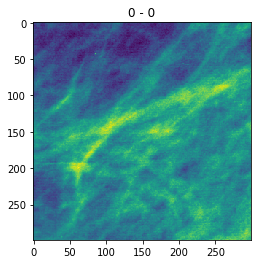

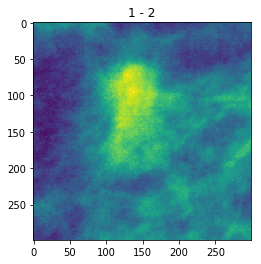

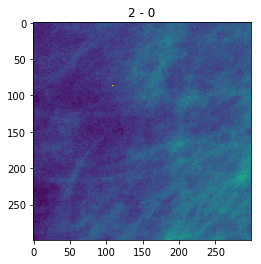

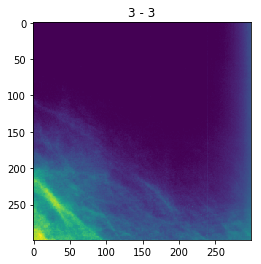

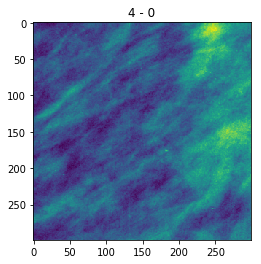

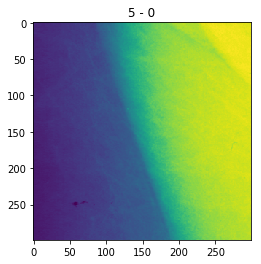

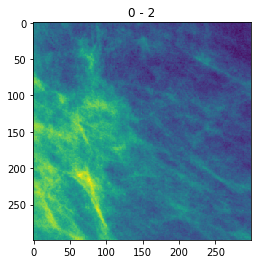

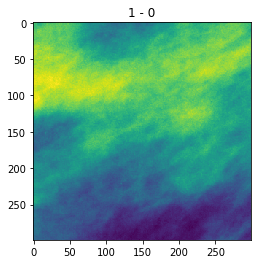

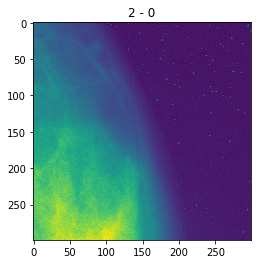

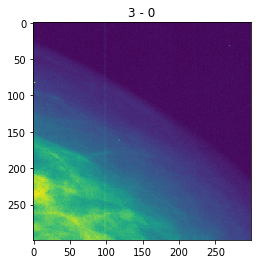

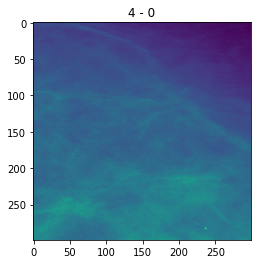

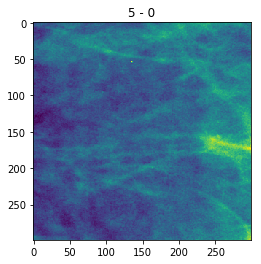

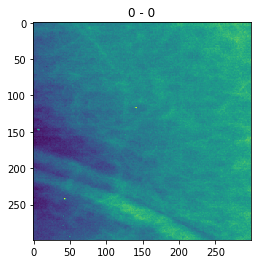

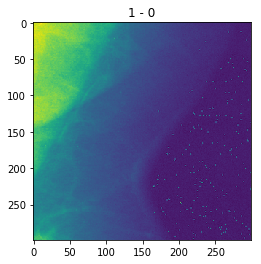

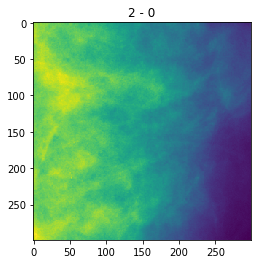

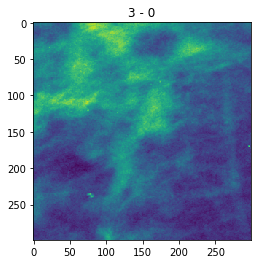

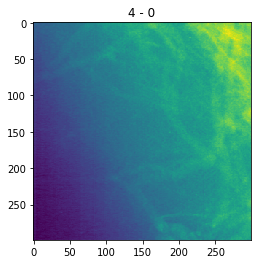

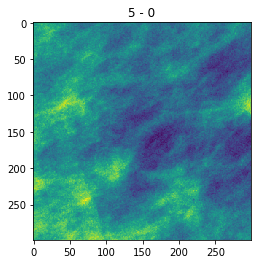

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for j in range(3):
        la_b, im_b = sess.run([labels_batch, images_batch])

        for i in range(6):
            plt.imshow(im_b[i].reshape([299,299]))
            plt.title(str(i) + " - " + str(la_b[i]))
            plt.show()

    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    